# Momentum method for optimization

The famous second Newton's law describes a motion (described by a position vector $\mathbf x(t)$ and velocity $\mathbf v$(t)) of a point of mass $m$ in the gradient force field (force given by the negative of the gradient of a potential field $f(\mathbf x)$) with the additional imposition of a friction (assuming a linear model of a friction $F_\mathrm{fr}=-b\mathbf v(t)$)

\begin{align*}
\dot{\mathbf x}(t) &= \mathbf v(t)\\
\dot{\mathbf v}(t) &= \frac{1}{m}\left[-\nabla f(\mathbf x)-b\mathbf v(t)\right].
\end{align*}

Equivalently, we can transform the state vector such that the second variable is momentum $\mathbf p(t)=m\mathbf v(t)$

\begin{align*}
\dot{\mathbf x}(t) &= \frac{1}{m}\mathbf p(t)\\
\dot{\mathbf p}(t) &= \underbrace{-\nabla f(\mathbf x)}_{\mathbf F_\mathrm{field}}-\underbrace{\frac{b}{m}\mathbf p(t)}_{\mathbf F_\mathrm{fr}(t)}.
\end{align*}

Time for some simulation. First off, the physical parameters

In [1]:
m = 5
b = 3

3

Now the potential function, from which the force is derived. Below we offer [Rosenbrock banana function](https://en.wikipedia.org/wiki/Rosenbrock_function).

In [2]:
a₁ = 1
a₂ = 5
f(x::Vector) = a₂*(x[2]-x[1]^2)^2 + (a₁-x[1])^2

f (generic function with 1 method)

Let's now plot the contours for this function to get some picture about it.

In [3]:
x1_data = x2_data = -2:0.01:2;
f_data = [f([x1,x2]) for x2=x2_data, x1=x1_data];

In [4]:
using Plots

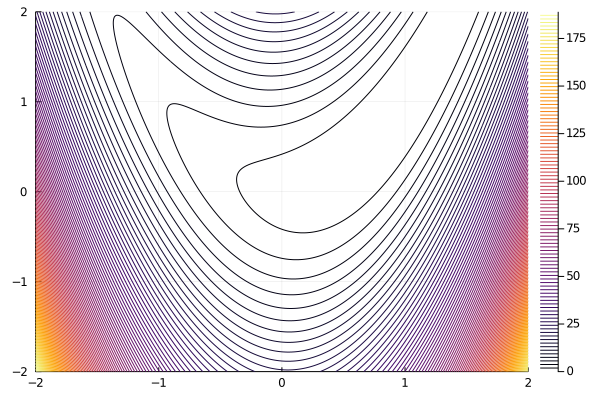

In [5]:
contour(x1_data,x2_data,f_data,levels=100)

The highest time for the actual numerical simulation. Although we can find the gradient vector just using a pen and paper in this case, we can also find a gradient of the function using one of those Julia packages that provide [algorithmic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)

In [6]:
using ForwardDiff

In [7]:
g = x->ForwardDiff.gradient(f,x)

#3 (generic function with 1 method)

Finally, we solve the ODE using the standard sequence of steps.

## Solving the ODE using dedicated solver(s)

In [8]:
using DifferentialEquations

In [9]:
p = [m,b,g]

3-element Array{Any,1}:
 5
 3
  #3 (generic function with 1 method)

In [10]:
function motioneq!(dy,y,p,t)
    m, b, g = p
    dy[1:2] = y[3:4]/m
    dy[3:4] = -g(y[1:2]) - b/m*y[3:4]
end

motioneq! (generic function with 1 method)

Initial conditions (positions and velocities)

In [11]:
x0 = [-1.5, 1.0]
p0 = [0.0, 0.0]
y0 = [x0; p0]

4-element Array{Float64,1}:
 -1.5
  1.0
  0.0
  0.0

In [12]:
tspan = (0.0,20.0)

(0.0, 20.0)

In [13]:
prob = ODEProblem(motioneq!,y0,tspan,p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 20.0)
u0: [-1.5, 1.0, 0.0, 0.0]

In [14]:
sol = solve(prob, reltol=1e-8, abstol=1e-8)

retcode: Success
Interpolation: automatic order switching interpolation
t: 176-element Array{Float64,1}:
  0.0
  0.017630315524054214
  0.041742027342130936
  0.06984400654085487
  0.10249420317194388
  0.13810983386437958
  0.1766107879934572
  0.217533264111422
  0.2610234872525644
  0.3073383176644402
  0.3573808317256132
  0.4138160410248643
  0.47643283548036347
  ⋮
 18.583005774447585
 18.71423346838753
 18.848327309002137
 18.9905891102677
 19.160401181863648
 19.292595186565542
 19.435563762378898
 19.56933261670263
 19.706771563301498
 19.84489930006214
 19.992139859290898
 20.0
u: 176-element Array{Array{Float64,1},1}:
 [-1.5, 1.0, 0.0, 0.0]
 [-1.4986844834693138, 1.0003869442605413, 0.7443685920819355, 0.21896321274208524]
 [-1.4926829396432573, 1.002152929563739, 1.7392723334791373, 0.5119553568189742]
 [-1.4797607485572033, 1.0059591885135457, 2.8484664939859825, 0.8395902541178273]
 [-1.4571937038212472, 1.0126184544551238, 4.044653282009585, 1.1948563830644356]
 [-1.4241

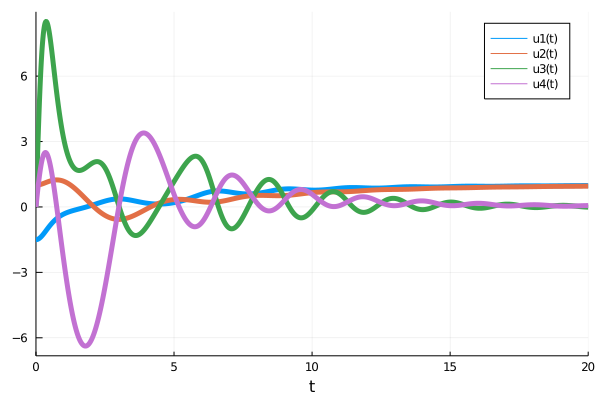

In [15]:
plot(sol,linewidth=5)

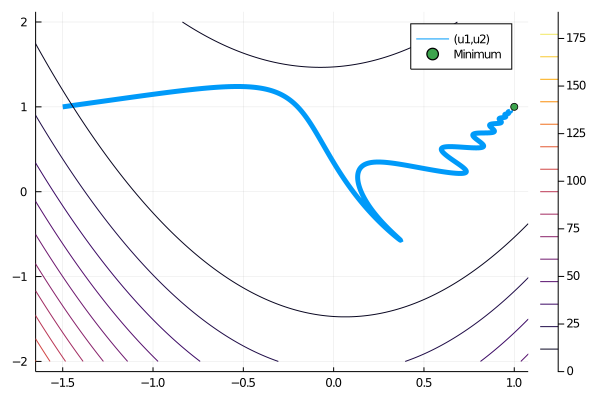

In [16]:
plot(sol,linewidth=5,vars=(1,2))
contour!(x1_data,x2_data,f_data)
scatter!([1,],[1,],label="Minimum")

The algorithms implemented in Julia ODE solvers that we used above do use some discretization in time. But below we develop one such scheme by ourselves.  

## Solving using a simple first-order finite difference approximation

We approximate the derivatives by finite differences $\dot{\mathbf x}(t)\approx \frac{\mathbf x(t+h)-\mathbf x(t)}{h}$ and $\dot{\mathbf p}(t)\approx \frac{\mathbf p(t+h)-\mathbf p(t)}{h}$. Upon introducing the notation for approximate values such as $\mathbf x_k$ for $\mathbf x(t)$ and $\mathbf x_{k+1}$ for $\mathbf x(t+h)$ we turn the differential equations into the recurrent scheme 

\begin{align*}
\frac{\mathbf x_{k+1}-\mathbf x_k}{h} &= \frac{1}{m}\mathbf p_k\\
\frac{\mathbf p_{k+1}-\mathbf p_k}{h} &= -\nabla f(\mathbf x_k)-\frac{b}{m}\mathbf v_k,
\end{align*}

which can be rewritten into

\begin{align*}
\mathbf x_{k+1} &=  \mathbf x_k + \underbrace{\frac{h}{m}}_{\gamma}\mathbf p_k\\
\mathbf p_{k+1} &=  \underbrace{\left(1- \frac{hb}{m}\right)}_{\beta} \mathbf p_k - \underbrace{h}_{\alpha}\nabla f(\mathbf x_k).
\end{align*}

Let's choose the single parameter $h$

In [17]:
h = 0.1

0.1

In [18]:
γ = h/m
α = h
β = 1-h*b/m

0.94

In [19]:
y0

4-element Array{Float64,1}:
 -1.5
  1.0
  0.0
  0.0

In [20]:
X = [x0,]

1-element Array{Array{Float64,1},1}:
 [-1.5, 1.0]

In [21]:
P = [p0,]

1-element Array{Array{Float64,1},1}:
 [0.0, 0.0]

In [22]:
t = 0

0

In [23]:
while t<=tspan[2]
    push!(X,X[end]+γ*P[end])
    push!(P,β*P[end]-α*g(X[end]))
    t += h
end

In [24]:
Xsol = hcat(X...)';
Psol = hcat(P...)';

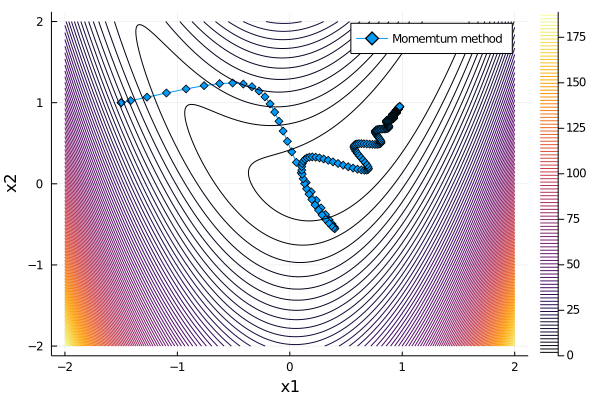

In [25]:
plot(Xsol[:,1],Xsol[:,2],marker=:diamond,xlabel="x1",ylabel="x2",label="Momemtum method")
contour!(x1_data,x2_data,f_data,levels=100)

Let's now have a look at how the norm of the error (the distance from the optimal solution which we know in advance for these textbook functions) evolves in time

In [26]:
using LinearAlgebra

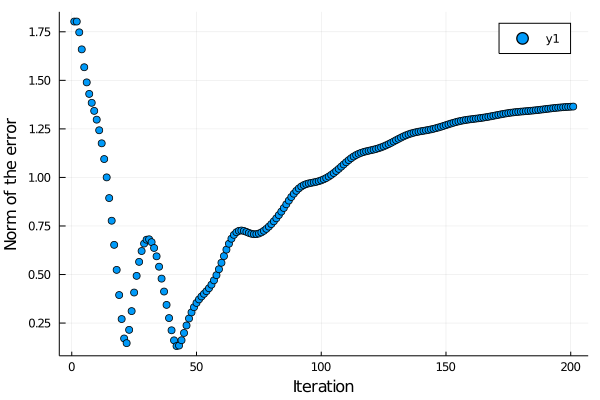

In [27]:
scatter(norm.(X),xlabel="Iteration",ylabel="Norm of the error")

## Negligible inertia

What if $m\approx 0$? Recall the motion equations with the position and velocity as the state variables

\begin{align*}
\dot{\mathbf x}(t) &= \mathbf v(t)\\
\underbrace{m\dot{\mathbf v}(t)}_{\approx 0} &= -\nabla f(\mathbf x)-b\mathbf v(t).
\end{align*}

The second equation reduces to 

$$
\mathbf v(t) = -\frac{1}{b}\nabla f(\mathbf x).
$$

In other words, the velocity is immediately set by the force derived from the potential field. The velocity is not a dynamical variable. The only dynamics is now in the position variable. Upon substitution we get

$$
\dot{\mathbf x}(t) = -\frac{1}{b}\nabla f(\mathbf x).
$$

Approximating the derivative on the left hand side by the forward Euler method, we get the following 

$$
\mathbf x_{k+1} =  \mathbf x_k - \underbrace{\frac{h}{b}}_{\eta}\nabla f(\mathbf x_k).
$$

Voila, gradient descent method with a fixed step length.

In [28]:
X = [x0,]

1-element Array{Array{Float64,1},1}:
 [-1.5, 1.0]

In [29]:
t = 0

0

In [30]:
#h = 0.1

In [31]:
η = h/b

0.03333333333333333

In [32]:
while t<=tspan[2]
    push!(X,X[end]-η*g(X[end]))
    t += h
end

In [33]:
Xsol = hcat(X...)';

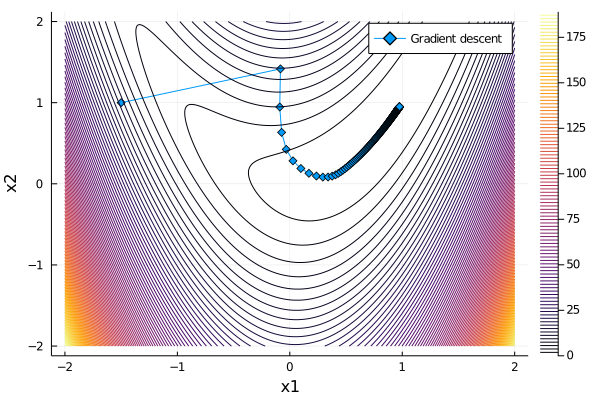

In [34]:
plot(Xsol[:,1],Xsol[:,2],marker=:diamond,xlabel="x1",ylabel="x2",label="Gradient descent")
contour!(x1_data,x2_data,f_data,levels=100)

In [35]:
# scatter(norm.(X.-[1,1]),xlabel="Iteration",ylabel="Norm of the error")

LoadError: [91mDimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 201 and 2")[39m

In [36]:
# X .- [1,1]

LoadError: [91mDimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 201 and 2")[39m